In [29]:
import tensorflow as tf
import tensorflow_io as tfio
import matplotlib.pyplot as plt
import json
import os
from functools import partial
import time
import logging

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 

# funcs
def display_first_n_images(dataset, n, is_normalized=False):
    plt.figure(figsize=(20, 10))
    for i, (image, label) in enumerate(dataset.take(n)):
        plt.subplot(1, n, i+1)
        plt.imshow((image + 1) / 2 if is_normalized else image) # or plt.imshow(tf.cast((image + 1) * 127.5, tf.uint8))
        plt.title(label.numpy()) # category id
        plt.axis('off')
    plt.show()

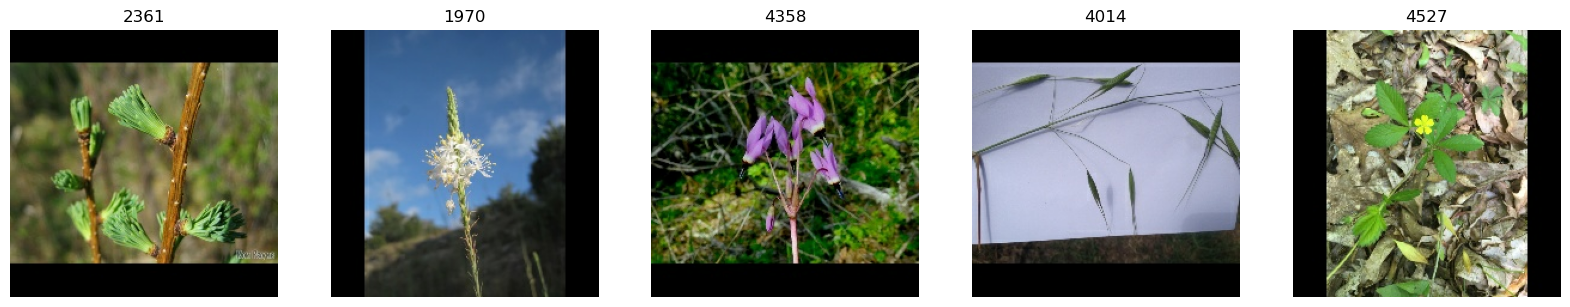

Image shape: (224, 224, 3)


In [65]:
feature_description = {
    "image": tf.io.FixedLenFeature([], tf.string),
    "label": tf.io.FixedLenFeature([], tf.int64)
}

def normalize_image(image):
    return tf.cast(image, tf.float32) / 127.5 - 1.0 # normalize to [-1, 1]

def parse_example(serialized_example):
    parsed_example = tf.io.parse_single_example(serialized_example, feature_description)

    # decode and normalize image, and extract label
    image = tf.image.decode_jpeg(parsed_example["image"], channels=3)
    image = normalize_image(image)
    label = parsed_example["label"]
    
    return image, label

def parse_example_safely(serialized_example):
    try:
        return parse_example(serialized_example)
    except tf.errors.InvalidArgumentError as e:
        tf.print(f"Error parsing example: {e}")
        return None, None # we can filter these entries from the dataset

def tfrecord_s3_generator(bucket_filepaths, batch_group_size=1):
    """
    Generator downloads batched .tfrecord files from S3. 
    Downloads, processes and deletes files to keep disk space consumption to a minimum.
    Managed in groups of batch_group_size, ensuring there are always at least this number of files
    on disk.
    """
    for i in range(0, len(bucket_filepaths), batch_group_size):
        grouped_bucket_filepaths = bucket_filepaths[i:i+batch_group_size]
        local_filepaths = []

        # handle bucket filepaths in groups
        for bucket_filepath in grouped_bucket_filepaths:
            bucket_filepath = bucket_filepath.decode('UTF-8') if isinstance(bucket_filepath, bytes) else bucket_filepath
            local_filepath = f"/tmp/inat17-tfrecords/{os.path.basename(bucket_filepath)}"
            local_filepaths.append(local_filepath)

            if not os.path.exists(local_filepath): # ensure downloaded
                os.system(f"aws s3 cp {bucket_filepath} {local_filepath}")
        
        dataset = tf.data.TFRecordDataset(local_filepaths, compression_type="GZIP")
        
        for example in dataset:
            yield example

        for local_filepath in local_filepaths:
            os.remove(local_filepath)

use_s3 = False # s3 or local drive

if use_s3:
    # construct dataset from generator, using S3 to download batches in sequence on demand
    bucket_filepaths = [f"s3://inat17-train-val-records/train_val_images-processed/val2017/inat17_batch-{i}-of-96.tfrecord" for i in range(1, 97)]
    dataset = tf.data.Dataset.from_generator(
        generator=tfrecord_s3_generator,
        args=(bucket_filepaths,),
        output_signature=tf.TensorSpec(shape=(), dtype=tf.string) # raw serialized examples
    )
else:
    local_filepaths = [f"/Volumes/t7/train_val_images-processed/val2017/inat17_batch-{i}-of-96.tfrecord" for i in range(1, 97)]
    dataset = tf.data.TFRecordDataset(
        local_filepaths, 
        compression_type="GZIP"
    )

dataset = (
    dataset
    .map(parse_example_safely, num_parallel_calls=tf.data.AUTOTUNE)
    .filter(lambda image, label: image is not None and label is not None)
)
display_first_n_images(dataset, 5, is_normalized=True)

for image, label in dataset.take(1):
    print(f"Image shape: {image.shape}")

In [63]:
import json

# read processed json batch annotations
with open(f"./train_val2017/categories.json", "r") as f:
    categories = json.load(f)

for image, label in dataset.take(3):
    print(f"{label.numpy()} : {categories[str(label.numpy())]}")

4040 : Mammalia/Procavia capensis
4040 : Mammalia/Procavia capensis
4040 : Mammalia/Procavia capensis
